### Carga de Base de datos y Librerias

In [49]:
# Cargamos todas las librerias que vamos a necesitar y abrimos la ruta al repositorio

# PARTE 1
!pip install openpyxl
!pip install matplotlib pandas
!pip install pandas pyreadstat
!pip install pandas numpy scikit-learn matplotlib
!pip install seaborn

import pandas as pd
import os # Exportamos este módulo para trabajar con carpetas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# PARTE 2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


#Cargamos el archivo desde el directorio del GitHub
base_dir = os.getcwd() # Construye la ruta relativa al archivo CSV desde el directorio actual

# ACTIVA EL GUARDADO DE CSV DE HOGARINDIVIDUAL PARA CHEQUEAR.

In [171]:
excel_path = os.path.join(base_dir, 'usu_hogar_T124.xlsx')
hogar_eph24 = pd.read_excel(excel_path)
hogar_eph04 = pd.read_stata('Hogar_t104.dta')
datos_individual = pd.read_csv('datos_individual.csv', low_memory=False)
datos_individual_original = pd.read_csv('datos_individual.csv', low_memory=False)

### Limpieza de Datos

#### Creamos base única

In [172]:
# NOS QUEDAMOS CON LOS DATOS DEL GRAN BUENOS AIRES en las dos bases de datos

# 2004
hogar_eph04= hogar_eph04[hogar_eph04['region']=='Gran Buenos Aires']
# 2024
hogar_eph24=hogar_eph24[hogar_eph24['REGION']==1]

In [173]:
# COINCIDENCIA DE COLUMNAS

#2004
hogar_eph04.columns = hogar_eph04.columns.str.lower()
#2024
hogar_eph24.columns = hogar_eph24.columns.str.lower()


combined_df = pd.concat([hogar_eph24, hogar_eph04], ignore_index=True, sort=False)

# Identifica columnas no compartidas
columns_df1 = set(hogar_eph04.columns)
columns_df2 = set(hogar_eph24.columns)

only_in_df1 = columns_df1 - columns_df2
only_in_df2 = columns_df2 - columns_df1

print("Columnas en 2004 pero no en 2024:", only_in_df1)
print("Columnas en 2024 pero no en 2004:", only_in_df2)

columns_to_remove_2004 = only_in_df1
columns_to_remove_2024 = only_in_df2

# Elimina las columnas de 2004
hogar_eph04 = hogar_eph04.drop(columns=columns_to_remove_2004, errors='ignore')

# Elimina las columnas de 2024
hogar_eph24 = hogar_eph24.drop(columns=columns_to_remove_2024, errors='ignore')

Columnas en 2004 pero no en 2024: {'idimph'}
Columnas en 2024 pero no en 2004: {'pondih'}


In [174]:
# CREAM0S UNICO DATA FRAME
df_hogar = pd.concat([hogar_eph04, hogar_eph24], ignore_index=True, sort=False)

In [175]:
df_hogar

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,rdeccfr,gdeccfr,pdeccfr,adeccfr,vii1_1,vii1_2,vii2_1,vii2_2,vii2_3,vii2_4
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,06,06,,04,1.0,0.0,98.0,0.0,0.0,0.0
1,125397,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Departamento,...,00,00,,00,1.0,0.0,98.0,0.0,0.0,0.0
2,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,07,07,,05,1.0,0.0,98.0,0.0,0.0,0.0
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,08,08,,06,2.0,0.0,3.0,4.0,0.0,0.0
4,125599,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1471.0,Casa,...,04,04,,02,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,TQRMNOPSSHKMROCDEIJAH00861731,1.0,1,2024.0,1,1,S,33,3772.0,1,...,10,10.0,NaN,10,1,0,96,0,0,0
4892,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,2,2.0,NaN,2,4,2,98,0,0,0
4893,TQRMNOQQWHKMOQCDEIJAH00861732,1.0,1,2024.0,1,1,S,33,2639.0,1,...,12,12.0,NaN,12,2,0,98,0,0,0
4894,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,10,10.0,NaN,10,1,0,98,0,0,0


In [176]:
# Hacer el merge con el parámetro indicator=True para agregar la columna '_merge'

#df_hogar = df_hogar.drop_duplicates(subset=['codusu', 'nro_hogar'])

df_completa = pd.merge(df_hogar, datos_individual, on=['codusu', 'nro_hogar'], indicator=False)
print("Columnas en df_completa:", df_completa.columns.tolist())

# Mostrar los resultados
print(f"Filas solo en df_hogar: {len(df_hogar)}")
print(f"Filas solo en datos_individual: {len(datos_individual)}")
print(f"Filas en ambos DataFrames: {len(df_completa)}")
print("Columnas en df_hogar:", df_hogar.columns.tolist())
print("Columnas en datos_individual:", datos_individual.columns.tolist())

print(f"Duplicados en df_hogar: {df_hogar[['codusu', 'nro_hogar']].duplicated().sum()}")
print(f"Duplicados en datos_individual: {datos_individual[['codusu', 'nro_hogar']].duplicated().sum()}")
# Ver las filas que no tienen coincidencia
#print("\nFilas solo en df_hogar (sin coincidencia en datos_individual):")
#print(solo_df_hogar)


# Verifica si hay valores nulos en las claves de unión
print("Valores nulos en 'codusu' de df_hogar:", df_hogar['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de df_hogar:", df_hogar['nro_hogar'].isnull().sum())
print("Valores nulos en 'codusu' de datos_individual:", datos_individual['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de datos_individual:", datos_individual['nro_hogar'].isnull().sum())


coincidencias_codusu = df_hogar['codusu'].isin(datos_individual['codusu']).sum()
coincidencias_nro_hogar = df_hogar['nro_hogar'].isin(datos_individual['nro_hogar']).sum()



print(f"Coincidencias de 'codusu': {coincidencias_codusu} de {len(df_hogar)} en df_hogar están en datos_individual")
print(f"Coincidencias de 'nro_hogar': {coincidencias_nro_hogar} de {len(df_hogar)} en df_hogar están en datos_individual")


#print("\nFilas solo en datos_individual (sin coincidencia en df_hogar):")
#print(datos_individual[['codusu', 'nro_hogar']])


completos = df_hogar[df_hogar['codusu'].isin(datos_individual['codusu']) & df_hogar['nro_hogar'].isin(datos_individual['nro_hogar'])]

print(f"Filas con coincidencia completa (tanto 'codusu' como 'nro_hogar'): {len(completos)}")


Columnas en df_completa: ['codusu', 'nro_hogar', 'realizada', 'ano4_x', 'trimestre_x', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf_x', 'decifr_x', 'idecifr_x', 'rdecifr_x', 'gdecifr_x', 'pdecifr_x', 'adecifr_x', 'ipcf_x', 'deccfr_x', 'ideccfr_x', 'rdeccfr_x', 'gdeccfr_x', 'pdeccfr_x', 'adeccfr_x', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ano4_y', 'trimestre_y', 'region_y', 'mas_500_y', 'aglomerado_y', 'pondera_y', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch

In [177]:
# Crear una lista para almacenar las columnas finales
columns_final = []

# Usar un set para evitar duplicados en los nombres base
columns_base = set()

# Iterar sobre las columnas del DataFrame
for col in df_completa.columns:
    # Quitar los sufijos '_x' y '_y' del nombre de la columna
    base_col = col.rstrip('_x').rstrip('_y')
    # Si la columna base ya fue procesada, pasar a la siguiente
    if base_col in columns_base:
        continue
    # Si no, agregar el nombre base al set de columnas procesadas
    columns_base.add(base_col)
    # Verificar si las columnas '_x' y '_y' existen en el DataFrame
    if base_col + '_x' in df_completa.columns and base_col + '_y' in df_completa.columns:
        # Conservar la columna '_x' (puedes cambiar esto a '_y' si prefieres)
        columns_final.append(base_col + '_x')
    elif base_col + '_x' in df_completa.columns:
        columns_final.append(base_col + '_x')
    elif base_col + '_y' in df_completa.columns:
        columns_final.append(base_col + '_y')
    else:
        # Si no hay sufijos, agregar la columna directamente
        columns_final.append(base_col)

# Renombrar las columnas para quitar los sufijos '_x' y '_y'
df_completa = df_completa[columns_final].rename(columns=lambda x: x.rstrip('_x').rstrip('_y'))

In [178]:
#df_completa.to_csv('C:/Users/Mili/Downloads/hogarindividual.csv', index=False)

In [179]:
print(df_completa.columns.tolist())

['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4

In [180]:
print("Total de filas:", df_completa.shape[0])

Total de filas: 13284


In [181]:
#df_completa
#f_completa.to_csv("C:/Users/Mili/Downloads/rtrtrtrtetretert.csv", index=False)

####  Valores faltantes 

In [182]:
# Eliminar las columnas donde todas las filas son NaN
#df_completa_prueba = df_completa
print("Valores únicos antes del reemplazo:", df_completa['estado'].unique())  

for col in df_completa.columns:
    if df_completa[col].dtype in ['float64', 'int64']:  # Verificar si la columna es numérica
      if df_completa[col].apply(lambda x: isinstance(x, (int, float))).all():  
            df_completa[col] = df_completa[col].replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

#df_completa_prueba["estado"] = df_completa_prueba["estado"].replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

print("Valores únicos después del reemplazo:", df_completa['estado'].unique())  
      

# Asegurarnos de que los valores NaN en las columnas relevantes se eliminen
#df_completa_prueba = df_completa_prueba.dropna(subset=['estado'])
df_completa= df_completa.dropna(subset=['estado'])
print("Valores únicos finales:", df_completa['estado'].unique()) 

# Verificar los valores únicos después de dropna
#print("Valores únicos después de dropna:", df_completa_prueba['estado'].unique())  
#print("Valores únicos finales de 'estado':", df_completa_prueba['estado'].unique())

Valores únicos antes del reemplazo: [3 1 2 4 0]
Valores únicos después del reemplazo: [ 3.  1.  2.  4. nan]
Valores únicos finales: [3. 1. 2. 4.]


In [183]:
# Obtener los nombres de las columnas con valores NaN
print("CON ALGUN NAN:")
col = df_completa.columns[df_completa.isna().any()]
col_list = col.tolist()
print(col_list)

print("SIN NINGUN NAN:")
col_no_nan = df_completa.columns[df_completa.notna().all()]
col_no_nan_list = col_no_nan.tolist()
print(col_no_nan_list)

CON ALGUN NAN:
['iv1_esp', 'iv3_esp', 'iv7_esp', 'ii3_1', 'ii5_1', 'ii6_1', 'ii7_esp', 'ii8_esp', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'idecifr', 'pdecifr', 'ipcf', 'ideccfr', 'pdeccfr', 'h15', 'ch03', 'ch06', 'ch08', 'ch14', 'ch15_cod', 'ch16_cod', 'cat_inac', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09a', 'pp09a_esp', 'pp09b', 'pp09c', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a', 'pp11b_cod', 'pp11b1', 'pp11

In [184]:
#FILAS CON NAN

#df_completa = df_completa.dropna(subset=['cat_inac'])


print("Valores únicos después del reemplazo:", df_completa['cat_inac'].unique())  
#df_completa= df_completa.dropna(subset=['cat_inac'])
#print("Valores únicos finales:", df_completa['cat_inac'].unique()) 


print("Valores únicos después del reemplazo:", df_completa['itf'].unique())  
df_completa= df_completa.dropna(subset=['itf'])
print("Valores únicos finales:", df_completa['itf'].unique()) 

df_completa= df_completa.dropna(subset=['ch06'])
print("Valores únicos finales:", df_completa['ch06'].unique()) 

#df_completa = df_completa.dropna(subset=['estado'])
#COLUMNAS A ELIMINAR (vARIABLES NO CONSIDERADAS RELEVANTES)
df_completa = df_completa.drop(columns=['iv2', 'iv3', 'iv3_esp', 'iv4', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11']) #caracteristicas de la casa
df_completa = df_completa.drop(columns=['ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9']) #ii3 (ocupa casa para trabajar) y ii7 (regimen de tenencia del hogar) se quedan

Valores únicos después del reemplazo: [ 1. nan  4.  3.  5.  2.  7.  6.]
Valores únicos después del reemplazo: [3.6800e+02 4.4000e+02 2.1300e+03 ... 1.3007e+06 2.4800e+05 3.3900e+05]
Valores únicos finales: [3.6800e+02 4.4000e+02 2.1300e+03 ... 1.3007e+06 2.4800e+05 3.3900e+05]
Valores únicos finales: [79. 74. 54. 51. 25. 20. 55. 48. 17. 15. 77. 50. 26. 22. 18. 86. 62. 76.
 45. 41. 21. 31. 19. 52. 12. 32. 29. 64. 49. 10. 47. 43. 13.  3. 46. 78.
 60. 59. 37. 44. 30. 63. 71. 67. 87. 34. 14. 24. 28. 27. 69. 56. 33. 66.
 61.  1. 92. 65. 57. 23.  4. 40. 16. 83.  6. 38. 75. 11. 53. 73. 39. 35.
  7.  5. 36.  8. 82. 85. 72. 70. 89. 42.  2. 58. 68. 81. 80. 93. 96. 84.
 90. 94. 88. 98. 95. 91.]


In [185]:
print("Valores únicos finales:", df_completa['estado'].unique()) 


Valores únicos finales: [3. 1. 2. 4.]


In [186]:
df_completa

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,v5_m,v8_m,v9_m,v10_m,v11_m,v12_m,v18_m,v19_am,v21_m,t_vi
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,368.0
1,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,440.0
2,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13280,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13281,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,200000.0
13282,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,185000.0


In [187]:
column_types = df_completa.dtypes

# Crear una función para identificar columnas con tipos de datos mezclados
def columnas_tipos_mixtos(df):
    columnas_mixtas = []
    for columna in df.columns:
        tipos_unicos = df[columna].apply(type).unique()  # Obtener tipos únicos en la columna
        if len(tipos_unicos) > 1:  # Si hay más de un tipo de dato en la columna
            columnas_mixtas.append(columna)
    return columnas_mixtas

# Llamar a la función para encontrar las columnas con tipos de datos mezclados
columnas_mixtas = columnas_tipos_mixtos(df_completa)

# Imprimir el resultado
print("Columnas con tipos de datos mezclados:", columnas_mixtas)
print("Columnas con tipos de datos mezclados:", len(columnas_mixtas))

Columnas con tipos de datos mezclados: ['realizada', 'trimestre', 'region', 'aglomerado', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'ch14', 'ch15_cod', 'ch16_cod', 'pp03c', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp09a', 'pp09a_esp', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp

In [188]:
#Agregar una columna llamada desocupado: vale 1 si está desocupado y 0 cc
df_completa['desocupado'] = df_completa['estado'].apply(lambda x: 1 if x in [2] else 0)

In [189]:
#df_completa.to_csv('C:/Users/Mili/Downloads/PRUEBA.csv', index=False)

###  Variables construidas

In [190]:
# PROPORCION DE PERSONAS QUE TRABAJAN EN EL HOGAR Y CANTIDAD DE PERSONAS QUE VIVEN EN EL HOGAR.

trabajadores = df_completa[df_completa['estado'] == 1]  # Filtramos por las personas que están trabajando
total_personas_hogar = df_completa.groupby(['codusu', 'nro_hogar']).size().reset_index(name='total_personas') #Agrupar por hogar y contar el TOTAL de personas en cada hogar
trabajadores_por_hogar = trabajadores.groupby(['codusu', 'nro_hogar']).size().reset_index(name='personas_trabajando') # Agrupar por hogar y contar el número de personas QUE TRABAJAN

proporcion_trabajadores = pd.merge(total_personas_hogar, trabajadores_por_hogar, on=['codusu', 'nro_hogar'], how='left') # Unimos los datos de trabajadores y el total de personas en cada hogar
proporcion_trabajadores['personas_trabajando'] = proporcion_trabajadores['personas_trabajando'].fillna(0) # Si no hay trabajadores en un hogar, rellenamos con 0
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['personas_trabajando'] / proporcion_trabajadores['total_personas'] # Calcular la proporción de trabajadores en cada hogar

# Resultado final: mostrar la proporción de trabajadores en cada hogar
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['proporcion_trabajando'].round(3)
print(proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando']])

df_completa = pd.merge(df_completa, proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']], on=['codusu', 'nro_hogar'], how='left')

                             codusu  nro_hogar  proporcion_trabajando
0                          125047          1.0                  0.000
1                          125098          1.0                  0.000
2                          125169          1.0                  0.333
3                          125172          2.0                  1.000
4                          125256          1.0                  0.667
...                             ...        ...                    ...
3897  TQTMNORQXHMOSQCDEIJAH00802270        1.0                  0.667
3898  TQTMNORTYHJOPMCDEIJAH00794674        1.0                  1.000
3899  TQTMNOSPRHMNROCDEIJAH00860644        1.0                  1.000
3900  TQTMNOSTRHLMKUCDEIJAH00861152        1.0                  0.500
3901  TQUMNOQSVHMOTSCDEIJAH00859221        1.0                  1.000

[3902 rows x 3 columns]


In [191]:
# Calcular la tasa parcial
# Seleccionar las columnas necesarias
df_parcial = df_completa[['v3_m', 'v5_m', 'itf']] # v3_m = INDEMNIZACION POR DESPIDO   //  v5_m = SUBSIDIO O AYUDA SOCIAL  // itf = ingreso total familiar
df_parcial[['v3_m', 'v5_m']] = df_parcial[['v3_m', 'v5_m']].fillna(0)
print(df_parcial[['v3_m', 'v5_m']].isna().sum())  # Debe devolver 0 para ambas columnas


# Reemplazar valores nulos en la columna 'itf' con 1 (porque es el denominador)
df_parcial['itf'] = df_parcial['itf'].fillna(1)

# Calcular la tasa
df_parcial['tasa'] = (df_parcial['v3_m'] + df_parcial['v5_m']) / df_parcial['itf']

# Mostrar las filas donde tasa_parcial es mayor a 0
#v = df_parcial[df_parcial['tasa'] > 0.5]  

df_completa['tasa_parcial'] = (df_parcial['tasa'] > 0.5).astype(int)  # Si La tasa de ingreso familiar DEPENDE MAS DEL 0.5 A AYUDA SOCIAL O INDEMINZACION POR DESPIDO  == 1 VA A SER MUY PROBABLE QUE ESTE DESEMPLEADO. 

#10407 EMPLEADOS CUMPLEN ESA CONDICION DE 10451 --> COINCIDE BIEN CON EMPLEADOS, LOS DESEMPLEADOS NO CUMPLEN TANTO ESTA CONDICION DE INGRESO POR SEGURO DE DESEMPLEO O PLAN SOCIAL

valores_unicos = df_completa['desocupado'].unique()
print("Valores únicos en la columna:")
print(valores_unicos)
# -----------------------------------------------------

grupo_filtrado = df_completa[(df_completa['tasa_parcial'] == 0) & (df_completa['desocupado'] == 0)]

# Imprimir las filas filtradas
print(grupo_filtrado)
cantidad_desempleados = df_completa[df_completa['desocupado'] == 1].shape[0]
print("cant de desempleados total: ",cantidad_desempleados)
cantidad_empleados = df_completa[df_completa['desocupado'] == 0].shape[0]
print("cant de empleados total: ",cantidad_empleados)

v3_m    0
v5_m    0
dtype: int64
Valores únicos en la columna:
[0 1]
                              codusu  nro_hogar realizada    ano4  \
0                           125098          1.0        Sí  2004.0   
1                           125515          1.0        Sí  2004.0   
2                           125558          1.0        Sí  2004.0   
3                           125558          1.0        Sí  2004.0   
4                           125558          1.0        Sí  2004.0   
...                              ...        ...       ...     ...   
11141  TQRMNOPWVHJLSSCDEIJAH00794914        1.0         1  2024.0   
11142  TQRMNOSXRHKMNMCDEIJAH00861733        1.0         1  2024.0   
11143  TQRMNORRQHMORPCDEIJAH00802469        1.0         1  2024.0   
11144  TQRMNORRQHMORPCDEIJAH00802469        1.0         1  2024.0   
11145  TQRMNORRQHMORPCDEIJAH00802469        1.0         1  2024.0   

            trimestre             region mas_500              aglomerado  \
0      1er. Trimestre  Gra

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\798397673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial[['v3_m', 'v5_m']] = df_parcial[['v3_m', 'v5_m']].fillna(0)
C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\798397673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial['itf'] = df_parcial['itf'].fillna(1)
C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\798397673.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [192]:
# PROMEDIO EDAD HOGAR HOGAR
df_completa['prom_edad_hogar'] = df_completa.groupby(['codusu', 'nro_hogar'])['ch06'].transform('mean')


df_parcial = df_completa[['ch06', "codusu", "nro_hogar", "desocupado"]] 
df_parcial['prom_edad_hogar'] = df_parcial.groupby(['codusu', 'nro_hogar'])['ch06'].transform('mean')
# Mostrar las filas donde tasa_parcial es mayor a 0
#v = df_parcial[df_parcial['tasa'] > 0.5]  

df_filtrado = df_parcial[df_parcial['desocupado'] == 1]

df_menor_20 = df_parcial[df_parcial['prom_edad_hogar'] < 20]

# Contar cuántas filas cumplen la condición
cantidad_menor_20 = df_menor_20.shape[0]

# Imprimir la cantidad
print(f"Cantidad de personas con edad promedio menor a 20: {cantidad_menor_20}")
porcentaje_menor_20 = (cantidad_menor_20 / df_parcial.shape[0]) * 100

# Imprimir el porcentaje
print(f"Porcentaje de personas con edad promedio de hogar menor a 20: {porcentaje_menor_20:.2f}%")

# Calcular la proporción de desocupado == 1 entre las personas con edad promedio hogar menor a 20
proporcion_desocupado_1 = df_menor_20[df_menor_20['desocupado'] == 1].shape[0] / cantidad_menor_20

# Calcular la proporción de desocupado == 0 entre las personas con edad promedio menor a 20
proporcion_desocupado_0 = df_menor_20[df_menor_20['desocupado'] == 0].shape[0] / cantidad_menor_20

# Imprimir las proporciones
print(f"Proporción de desocupado con edad promedio menor a 20 (considerando solo menores a 20): {proporcion_desocupado_1}")
print(f"Proporción de ocupado con edad promedio menor a 20 (considerando solo menores a 20): {proporcion_desocupado_0}")




C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\849282110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial['prom_edad_hogar'] = df_parcial.groupby(['codusu', 'nro_hogar'])['ch06'].transform('mean')


Cantidad de personas con edad promedio menor a 20: 1640
Porcentaje de personas con edad promedio de hogar menor a 20: 14.71%
Proporción de desocupado con edad promedio menor a 20 (considerando solo menores a 20): 0.046341463414634146
Proporción de ocupado con edad promedio menor a 20 (considerando solo menores a 20): 0.9536585365853658


In [193]:
hogares_menor_20 = df_parcial[df_parcial['prom_edad_hogar'] < 20]

# Contar el número de personas (componentes) por hogar
conteo_componentes = hogares_menor_20.groupby(['codusu', 'nro_hogar']).size()

# Ver cuántos hogares tienen 1, 2, 3, 5, 12 personas (componentes)
conteo_rango_componentes = conteo_componentes.value_counts()

# Imprimir el conteo de hogares con diferentes cantidades de componentes
print("Cantidad de hogares con diferentes cantidades de componentes:")
print(conteo_rango_componentes)

Cantidad de hogares con diferentes cantidades de componentes:
4     109
3      90
5      68
6      35
2      28
7      20
8       8
1       5
9       5
10      4
11      2
12      1
Name: count, dtype: int64


###  Estadísticas Descriptivas

    total_personas  media_proporcion_trabajando  cantidad_hogares
0                1                     0.505143               875
1                2                     0.456459              1045
2                3                     0.494647               812
3                4                     0.418750               600
4                5                     0.359615               312
5                6                     0.336971               138
6                7                     0.309328                61
7                8                     0.322581                31
8                9                     0.281333                15
9               10                     0.340000                 5
10              11                     0.318500                 4
11              12                     0.208000                 2
12              14                     0.429000                 1
13              15                     0.333000                 1


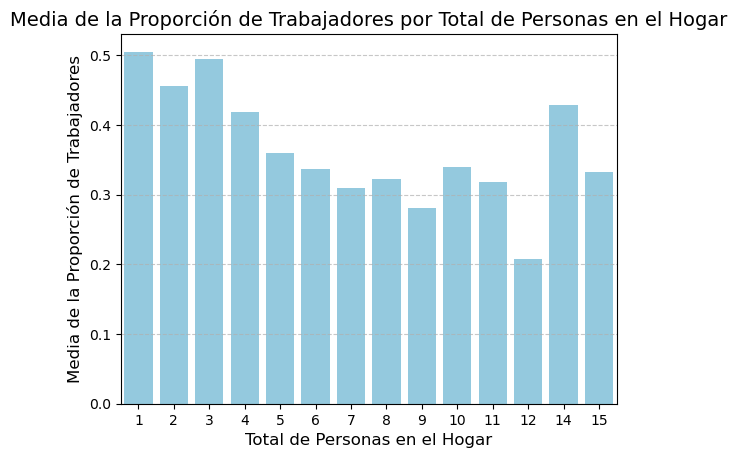

In [73]:
# Asegurarnos de que cada hogar esté representado una sola vez
hogares_unicos = df_completa[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']].drop_duplicates(subset=['codusu', 'nro_hogar'])

# 0.000 865: Significa que hay 865 hogares donde la proporción de personas que trabajan es 0 (es decir, nadie trabaja en esos hogares).

# Agrupar por total_personas y calcular la media de la proporcion_trabajando
tabla_resumen = hogares_unicos.groupby('total_personas').agg(
    media_proporcion_trabajando=('proporcion_trabajando', 'mean'),
    cantidad_hogares=('codusu', 'size')
).reset_index()

# Ordenar por total_personas para mayor claridad
tabla_resumen = tabla_resumen.sort_values(by='total_personas')

# Mostrar la tabla
print(tabla_resumen)


# Crear un gráfico de barras para la media de la proporción de trabajadores
sns.barplot(data=tabla_resumen, x='total_personas', y='media_proporcion_trabajando', color='skyblue')

# Agregar etiquetas y título
plt.title('Media de la Proporción de Trabajadores por Total de Personas en el Hogar', fontsize=14)
plt.xlabel('Total de Personas en el Hogar', fontsize=12)
plt.ylabel('Media de la Proporción de Trabajadores', fontsize=12)

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

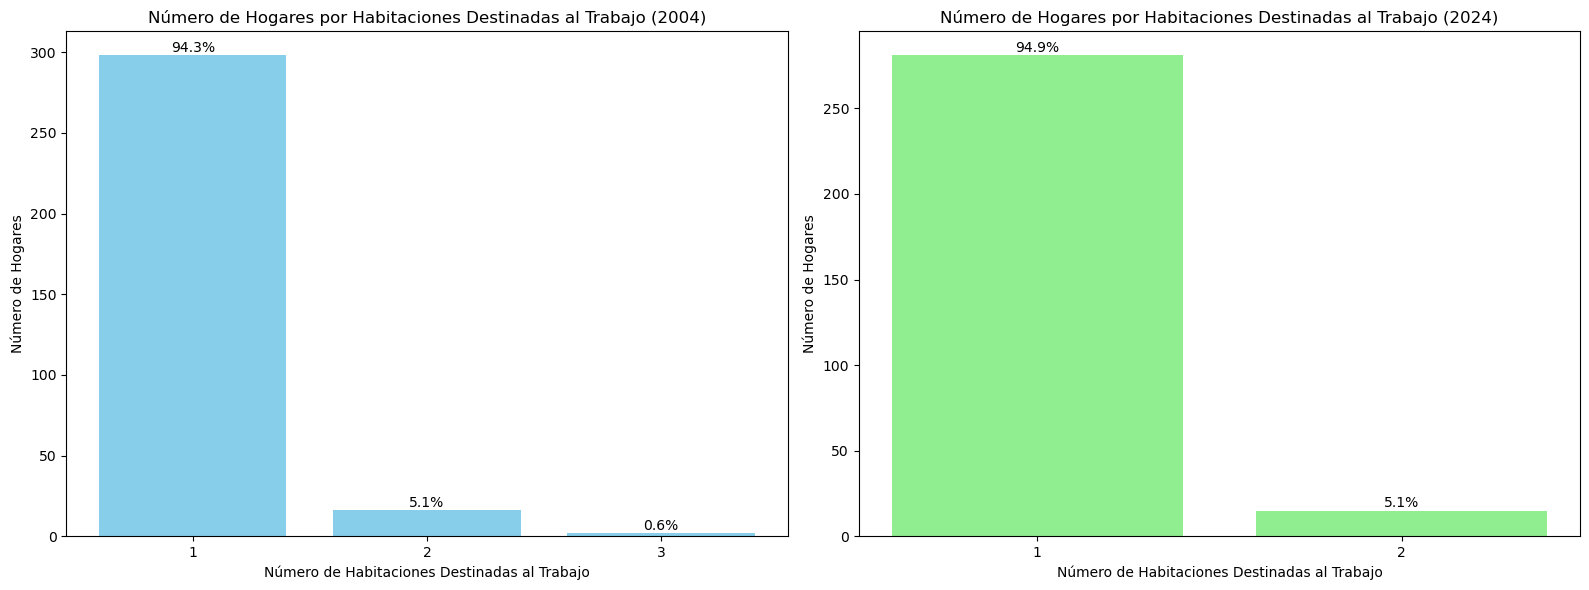

Resumen de Hogares por Habitaciones Destinadas al Trabajo (2004):
   ii3_1  cantidad_hogares  porcentaje
0      1               298        94.3
1      2                16         5.1
2      3                 2         0.6

Resumen de Hogares por Habitaciones Destinadas al Trabajo (2024):
   ii3_1  cantidad_hogares  porcentaje
0      1               281        94.9
1      2                15         5.1


In [74]:
# Filtrar los hogares por el año (asumiendo que tienes una columna 'ano4')
df_2004_limpio = df_completa[df_completa['ano4'] == 2004]
df_2024_limpio = df_completa[df_completa['ano4'] == 2024]
df_2004_limpio = df_2004_limpio.dropna(subset=['ii3_1'])
df_2024_limpio = df_2024_limpio.dropna(subset=['ii3_1'])

# Calcular la cantidad de hogares por número de habitaciones destinadas al trabajo en 2004
hogares_por_habitacion_trabajo_2004 = df_2004_limpio.groupby('ii3_1').size().reset_index(name='cantidad_hogares')
hogares_por_habitacion_trabajo_2004['porcentaje'] = (hogares_por_habitacion_trabajo_2004['cantidad_hogares'] / df_2004_limpio.shape[0]) * 100

# Filtrar para eliminar las filas con porcentaje 0
hogares_por_habitacion_trabajo_2004 = hogares_por_habitacion_trabajo_2004[hogares_por_habitacion_trabajo_2004['porcentaje'] > 0]


# Calcular la cantidad de hogares por número de habitaciones destinadas al trabajo en 2024
hogares_por_habitacion_trabajo_2024 = df_2024_limpio.groupby('ii3_1').size().reset_index(name='cantidad_hogares')
hogares_por_habitacion_trabajo_2024['porcentaje'] = (hogares_por_habitacion_trabajo_2024['cantidad_hogares'] / df_2024_limpio.shape[0]) * 100

# Convertir ii3_1 a enteros para el eje x
hogares_por_habitacion_trabajo_2004['ii3_1'] = hogares_por_habitacion_trabajo_2004['ii3_1'].astype(int)
hogares_por_habitacion_trabajo_2024['ii3_1'] = hogares_por_habitacion_trabajo_2024['ii3_1'].astype(int)

# Crear gráficos para 2004 y 2024
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Crear dos gráficos en una fila

# Asegurarnos de que 'ii3_1' esté como enteros
hogares_por_habitacion_trabajo_2004['ii3_1'] = hogares_por_habitacion_trabajo_2004['ii3_1'].astype(int)
hogares_por_habitacion_trabajo_2024['ii3_1'] = hogares_por_habitacion_trabajo_2024['ii3_1'].astype(int)

# Forzar los ticks del eje x a los valores únicos de 'ii3_1'
ticks_2004 = hogares_por_habitacion_trabajo_2004['ii3_1'].unique()
ticks_2024 = hogares_por_habitacion_trabajo_2024['ii3_1'].unique()

# Gráfico para el año 2004
ax[0].bar(hogares_por_habitacion_trabajo_2004['ii3_1'], hogares_por_habitacion_trabajo_2004['cantidad_hogares'], color='skyblue')
ax[0].set_title('Número de Hogares por Habitaciones Destinadas al Trabajo (2004)')
ax[0].set_xlabel('Número de Habitaciones Destinadas al Trabajo')
ax[0].set_ylabel('Número de Hogares')
ax[0].set_xticks(ticks_2004)  # Establecer los ticks del eje x a los valores únicos

# Añadir los porcentajes sobre las barras
for i, row in hogares_por_habitacion_trabajo_2004.iterrows():
    ax[0].text(row['ii3_1'], row['cantidad_hogares'] + 2, f"{row['porcentaje']:.1f}%", ha='center')

# Gráfico para el año 2024
ax[1].bar(hogares_por_habitacion_trabajo_2024['ii3_1'], hogares_por_habitacion_trabajo_2024['cantidad_hogares'], color='lightgreen')
ax[1].set_title('Número de Hogares por Habitaciones Destinadas al Trabajo (2024)')
ax[1].set_xlabel('Número de Habitaciones Destinadas al Trabajo')
ax[1].set_ylabel('Número de Hogares')
ax[1].set_xticks(ticks_2024)  # Establecer los ticks del eje x a los valores únicos

# Añadir los porcentajes sobre las barras
for i, row in hogares_por_habitacion_trabajo_2024.iterrows():
    ax[1].text(row['ii3_1'], row['cantidad_hogares'] + 2, f"{row['porcentaje']:.1f}%", ha='center')


# Mostrar el gráfico
plt.tight_layout()
plt.show()
# Mostrar el resumen del año 2004
print("Resumen de Hogares por Habitaciones Destinadas al Trabajo (2004):")
print(resumen_2004)

# Resumen para el año 2024
resumen_2024 = hogares_por_habitacion_trabajo_2024[['ii3_1', 'cantidad_hogares', 'porcentaje']]
resumen_2024['porcentaje'] = resumen_2024['porcentaje'].round(1)  # Redondear los porcentajes a un decimal
resumen_2024 = resumen_2024.sort_values(by='ii3_1')  # Ordenar por el número de habitaciones

# Mostrar el resumen del año 2024
print("\nResumen de Hogares por Habitaciones Destinadas al Trabajo (2024):")
print(resumen_2024)

In [204]:
print(df_completa.columns.tolist())

print("SIN NINGUN NAN:")
col_no_nan = df_completa.columns[df_completa.notna().all()]
col_no_nan_list = col_no_nan.tolist()
print(col_no_nan_list)


df_temporal = df_completa.dropna(subset=['ix_men10', 'v19_a'])
df_temporal = df_temporal[['ix_men10', 'v19_a', 'codusu', 'nro_hogar', 'componente','v19_b']]

# Verificar los tipos de datos de cada columna
print(df_temporal.dtypes)

print("Valores únicos de 'ix_men10':")
print(df_temporal['ix_men10'].unique())

df_temporal['v19_a'] = df_temporal['v19_a'].replace({'No': 2, 'Sí': 1})

# Verificar el resultado
print(df_temporal['v19_a'].unique())
# Verificar la cantidad de veces que aparece cada valor en 'v19_a'
print(df_temporal['v19_a'].value_counts())

print(df_temporal['v19_b'].value_counts())

['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', '

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\2758755987.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temporal['v19_a'] = df_temporal['v19_a'].replace({'No': 2, 'Sí': 1})


['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', '

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\1785333350.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temporal['v19_a'] = df_temporal['v19_a'].replace({'No': 2, 'Sí': 1}).astype(int)


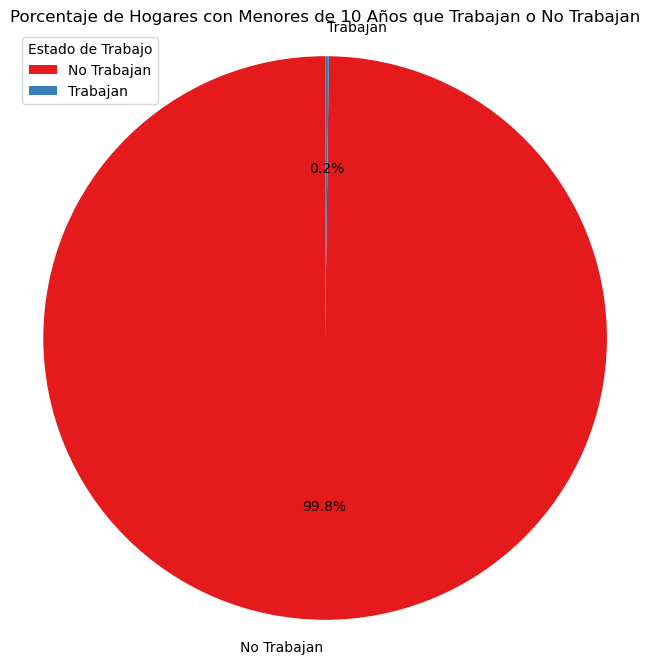

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar todas las columnas de df_completa
print(df_completa.columns.tolist())

# Imprimir las columnas que no tienen ningún NaN
print("SIN NINGUN NAN:")
col_no_nan = df_completa.columns[df_completa.notna().all()]
col_no_nan_list = col_no_nan.tolist()
print(col_no_nan_list)


# Filtrar y limpiar el DataFrame
df_temporal = df_completa.dropna(subset=['ix_men10', 'v19_a'])
df_temporal = df_temporal[['ix_men10', 'v19_a', 'codusu', 'nro_hogar', 'componente', 'v19_b']]

# Reemplazar los valores de 'v19_a' de 'No' y 'Sí' por 2 y 1 respectivamente
df_temporal['v19_a'] = df_temporal['v19_a'].replace({'No': 2, 'Sí': 1}).astype(int)

# Filtrar los hogares con menores de 10 años
df_menores_10 = df_temporal[df_temporal['ix_men10'] >= 1]

# Crear una columna adicional para "trabajo"
df_menores_10.loc[:, 'trabajo'] = df_menores_10['v19_a']  # 1 para 'Sí' (trabaja), 2 para 'No' (no trabaja)

# Calcular los porcentajes de hogares que trabajan y no trabajan
trabajo_counts = df_menores_10['trabajo'].value_counts(normalize=True) * 100



# Reemplazar 1 y 2 por etiquetas
trabajo_counts.index = ['Trabajan' if x == 1 else 'No Trabajan' for x in trabajo_counts.index]

# Crear un gráfico de torta (pie chart) con los porcentajes
plt.figure(figsize=(8, 8))
plt.pie(trabajo_counts, labels=trabajo_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set1", n_colors=2))

# Configuración del gráfico
plt.title('Porcentaje de Hogares con Menores de 10 Años que Trabajan o No Trabajan')
plt.axis('equal')  # Para que el gráfico sea un círculo perfecto

# Añadir leyenda para explicar los colores
plt.legend(trabajo_counts.index, title='Estado de Trabajo', loc='upper left')

plt.show()

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\4219528048.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_trabajan.loc[:, 'limosna'] = df_trabajan['v19_b'].replace({'No': 2, 'Sí': 1}).astype(int)
C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\4219528048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trabajan.loc[:, 'limosna'] = df_trabajan['v19_b'].replace({'No': 2, 'Sí': 1}).astype(int)
C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\4219528048.py:15: FutureWarning: 

Passing `palette` without assigni

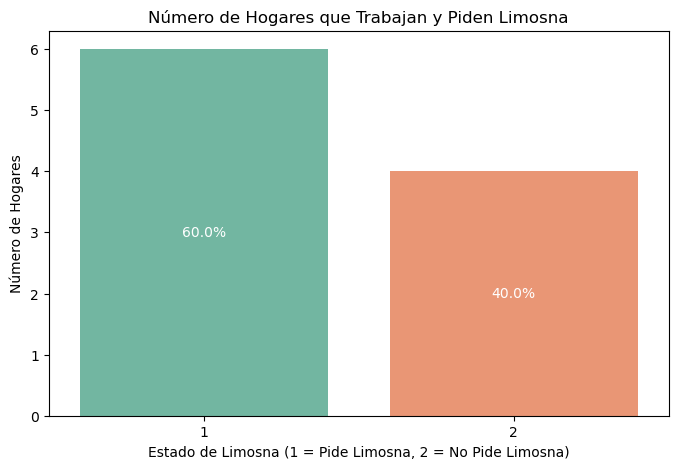

In [242]:

# Filtrar los hogares que trabajan
df_trabajan = df_menores_10[df_menores_10['trabajo'] == 1]

# Crear una columna adicional para "limosna"
df_trabajan.loc[:, 'limosna'] = df_trabajan['v19_b'].replace({'No': 2, 'Sí': 1}).astype(int)

# Calcular los conteos absolutos de limosna entre los hogares que trabajan
limosna_counts = df_trabajan['limosna'].value_counts()

# Calcular los porcentajes de limosna entre los hogares que trabajan
limosna_percentage = (limosna_counts / limosna_counts.sum()) * 100

# Crear un gráfico de barras con los conteos absolutos de limosna entre los hogares que trabajan
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=limosna_counts.index, y=limosna_counts.values, palette="Set2")

# Configuración del gráfico
plt.title('Número de Hogares que Trabajan y Piden Limosna')
plt.xlabel('Estado de Limosna (1 = Pide Limosna, 2 = No Pide Limosna)')
plt.ylabel('Número de Hogares')

# Colocar los porcentajes en el centro de las barras
for i, v in enumerate(limosna_counts.values):
    ax.text(i, v / 2, f'{limosna_percentage.iloc[i]:.1f}%', ha='center', va='center', fontsize=10, color='white')

# Mostrar el gráfico
plt.show()

### Clasificación y regularización

#### 2024

##### Preparación de la base

VOY a buscar la tabla de respondieron para agarrar las dummys.

In [345]:
# Base solo datos 2024
df_prediccion_2024 = df_completa[df_completa['ano4'] == 2024]

datos_respondieron_2024_individual = pd.read_csv('2024_respondieron.csv', low_memory=False)

In [346]:
# Obtener las columnas con valores NaN
columnas_con_na = df_prediccion_2024.isna().sum()

# Crear una lista de las columnas que tienen NaN
columnas_con_na_lista = columnas_con_na[columnas_con_na > 0].index.tolist()

# Imprimir la lista
print(columnas_con_na_lista)
# Eliminar columnas con NaN 
df_prediccion_2024 = df_prediccion_2024.dropna(axis=1)

columnas_con_na = df_prediccion_2024.isna().sum()

# Crear una lista de las columnas que tienen NaN
columnas_con_na_lista = columnas_con_na[columnas_con_na > 0].index.tolist()

# Imprimir la lista
print(columnas_con_na_lista)

['iv1_esp', 'ii3_1', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'idecifr', 'pdecifr', 'ideccfr', 'pdeccfr', 'h15', 'ch03', 'ch08', 'ch14', 'ch15_cod', 'ch16_cod', 'cat_inac', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09a', 'pp09a_esp', 'pp09b', 'pp09c', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a', 'pp11b_cod', 'pp11b1', 'pp11b2_mes', 'pp11b2_ano', 'pp11b2_dia', 'pp11c', 'pp11c99', 'pp11d_cod', 'pp11g_ano', 'pp11g_mes', 'pp1

In [347]:
print(df_prediccion_2024.columns.tolist())
columnas_a_borrar = ['ch06','ch04', 'ch07', 'ch08','nivel_ed', 'ipcf','ano4','cat_ocup','trimestre', 'region', 'mas_500', 'aglomerado', 'v4', 'vii2_4', 'ch11', 'estado', 'pondera']

# Eliminar las columnas con los nombres especificados
df_prediccion_2024 = df_prediccion_2024.drop(columns=[col for col in df_prediccion_2024.columns if any(sub in col for sub in columnas_a_borrar)])

# Verificar que las columnas fueron eliminadas
print(df_prediccion_2024.columns.tolist())



# ELIMINAMOS COLUMNAS QUE TIENEN DATOS NO ANALIZABLES YA TENEMOS MUY POCAS FILAS

# Convertir todas las columnas a numéricas (excepto 'codusu')
df_prediccion_2024 = df_prediccion_2024.apply(
    lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'codusu' else col
)

columnas_excluidas = ['componente', 'decocur', 'rdecocur', 'gdecocur', 'adecocur', 
                      'desocupado', 'proporcion_trabajando', 'total_personas', 
                      'tasa_parcial', 'prom_edad_hogar']



# Verificar las columnas que contienen los valores 0, 9 o 99, excluyendo las columnas específicas
columnas_a_eliminar = [col for col in df_prediccion_2024.columns 
                       if col not in columnas_excluidas and df_prediccion_2024[col].isin([0, 9, 99]).any()]

# Filtrar columnas que realmente existan en el DataFrame antes de intentar eliminarlas
columnas_a_eliminar_existentes = [col for col in columnas_a_eliminar if col in df_prediccion_2024.columns]

# Eliminar las columnas que contienen valores 0, 9 o 99, excluyendo las columnas especificadas
df_prediccion_2024 = df_prediccion_2024.drop(columns=columnas_a_eliminar_existentes)


# Verificar las columnas restantes
print(df_prediccion_2024.columns.tolist())

['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'itf', 'decifr', 'rdecifr', 'gdecifr', 'adecifr', 'ipcf', 'deccfr', 'rdeccfr', 'gdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'ch04', 'ch06', 'ch07', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch15', 'ch16', 'nivel_ed', 'estado', 'cat_ocup', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'decocur', 'rdecocur', 'gdecocur', 'adecocur', 'desocupado', 'proporcion_trabajando', 'total_personas', 'tasa_parcial', 'prom_edad_hogar']
['codusu', 'nro_hogar', 'realizada', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3',

In [348]:
#columnas_a_chequear = ['codusu', 'nro_hogar', 'realizada', 'pondera', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'v1', 'v2', 'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'itf', 'vii2_1', 'componente', 'ch16', 'estado', 'decocur', 'rdecocur', 'gdecocur', 'adecocur', 'desocupado', 'proporcion_trabajando', 'total_personas', 'tasa_parcial', 'prom_edad_hogar']

# Verificar qué columnas existen realmente en el DataFrame
#columnas_existentes = [columna for columna in columnas_a_chequear if columna in df_prediccion_2024.columns]

# Iterar sobre las columnas existentes y mostrar los valores únicos
#for columna in columnas_existentes:
#    print(f"Valores únicos en la columna '{columna}':")
#    print(df_prediccion_2024[columna].unique())
#    print("\n")

In [349]:
# Verificar si las columnas 'codusu' y 'nro_hogar' están en ambos DataFrames
df_prediccion_2024['componente'] = df_prediccion_2024['componente'].astype('int64')
columnas_requeridas = ['codusu', 'nro_hogar', 'componente']

df_prediccion_2024 = pd.merge(df_prediccion_2024, datos_respondieron_2024_individual, on=columnas_requeridas, how='inner')

In [350]:
# Eliminar columnas que comienzan con 'estado_' o 'inactividad_'
df_prediccion_2024 = df_prediccion_2024.drop(
    df_prediccion_2024.filter(regex='^estado_').columns, axis=1
)
df_prediccion_2024 = df_prediccion_2024.drop(
    df_prediccion_2024.filter(regex='^inactividad_').columns, axis=1
)
df_prediccion_2024 = df_prediccion_2024.drop(['codusu', 'nro_hogar', 'realizada'], axis=1)

In [351]:
non_numeric_columns = df_prediccion_2024.select_dtypes(exclude=['int64', 'float64']).columns

# Imprimir las columnas que no son numéricas
print(non_numeric_columns)

Index(['tasa_parcial'], dtype='object')


In [352]:
# Suponiendo que df_temporal es tu DataFrame específico
columnas_a_dummy = ['iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'v1', 'v2', 'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 
                    'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 
                    'itf', 'vii2_1', 'componente', 'ch16']

# Filtrar solo las columnas necesarias
df_seleccionado = df_prediccion_2024[columnas_a_dummy]

# Convertir esas columnas a variables dummy, eliminando la primera categoría para evitar multicolinealidad
df_dummies = pd.get_dummies(df_seleccionado, drop_first=True)
df_dummies = df_dummies.astype(int)
# Reemplazar el DataFrame original con las columnas dummy (sin las originales)
df_prediccion_2024 = pd.concat([df_prediccion_2024.drop(columns=columnas_a_dummy), df_dummies], axis=1)


In [303]:
df_prediccion_2024

,pondera,itf,componente,estado,decocur,rdecocur,gdecocur,adecocur,desocupado,proporcion_trabajando,...,pp02c8_2,pp02e_1,pp02e_2,pp02e_3,pp02e_4,pp02e_5,pp02h_1,pp02h_2,pp02i_1,pp02i_2
0,2018.0,290000.0,1,1.0,6,5,6.0,3,0,1.000,...,0,0,0,0,0,0,0,0,0,0
1,817.0,1900000.0,1,1.0,10,10,10.0,9,0,1.000,...,0,0,0,0,0,0,0,0,0,0
2,817.0,1900000.0,2,1.0,7,6,6.0,4,0,1.000,...,0,0,0,0,0,0,0,0,0,0
3,2211.0,67500.0,1,3.0,0,0,0.0,0,0,0.000,...,0,0,0,0,0,0,0,1,0,1
4,1672.0,800000.0,1,1.0,10,10,10.0,9,0,1.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,1862.0,339000.0,4,1.0,1,1,1.0,2,0,0.750,...,0,0,0,0,0,0,0,0,0,0
3892,1497.0,740000.0,1,1.0,8,8,8.0,8,0,1.000,...,0,0,0,0,0,0,0,0,0,0
3893,3120.0,585000.0,1,3.0,0,0,0.0,0,0,0.333,...,0,0,0,0,0,0,0,1,0,1
3894,3120.0,585000.0,2,3.0,0,0,0.0,0,0,0.333,...,0,0,0,0,0,0,0,1,0,1


##### Predicciones

In [355]:
print(df_prediccion_2024.columns.tolist())

['decocur', 'rdecocur', 'gdecocur', 'adecocur', 'desocupado', 'proporcion_trabajando', 'total_personas', 'tasa_parcial', 'prom_edad_hogar', 'edad', 'ingreso', 'varon', 'mujer', 'con_pareja', 'sin_pareja', 'si_cobertura', 'no_cobertura', 'prim_inc', 'prim_com', 'sec_inc', 'sec_com', 'uni_inc', 'uni_comp', 'sin_instrucc', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'v1', 'v2', 'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'itf', 'vii2_1', 'componente', 'ch16']


In [375]:
from sklearn.preprocessing import StandardScaler

# 1. Dividir los datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
train, test = train_test_split(df_prediccion_2024, test_size=0.3, random_state=101)

# 2. Separar la variable dependiente (target) 'desocupado' en y_train (y_test para prueba)
y_train = train['desocupado']  # Esta es la variable que queremos predecir
y_test = test['desocupado']  # Lo mismo para el conjunto de prueba

# 3. Separar las características (features) que NO son 'desocupado'
X_train = train.drop(columns='desocupado')  # Eliminar 'desocupado' de las características
X_test = test.drop(columns='desocupado')  # Eliminar 'desocupado' del conjunto de prueba

# 4. Agregar la columna de intercepto (unos) a las características de entrenamiento y prueba
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values])  # con NumPy
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test.values])  # con NumPy


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisión del modelo de regresión logística: 0.9657827202737382
Matriz de confusión:
 [[1120    5]
 [  35    9]]
Área bajo la curva (AUC): 0.9333131313131313


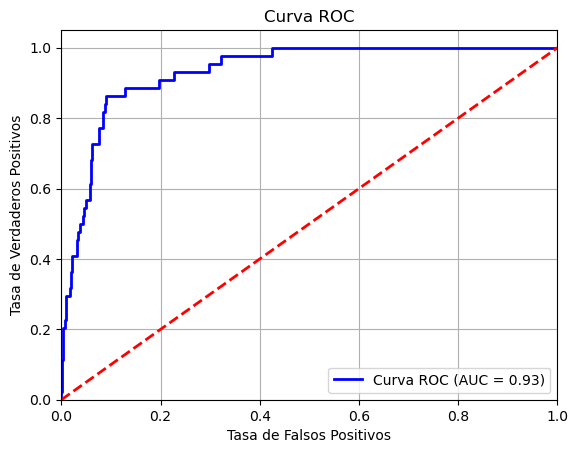

In [376]:
from sklearn.metrics import auc

# Modelo regresión logística
log_model = LogisticRegression(max_iter=1000)

# Entrenar el modelo
log_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = log_model.predict(X_test)

# Evaluar la precisión (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de regresión logística:", accuracy)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", conf_matrix)

# Calcular la curva ROC y el valor AUC
y_prob = log_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Área bajo la curva (AUC):", roc_auc)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Regularización L1 (LASSO)
model_lasso = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=101)
model_lasso.fit(X_train, y_train)

# Regularización L2 (Ridge)
model_ridge = LogisticRegression(penalty='l2', C=1, solver='liblinear', random_state=101)
model_ridge.fit(X_train, y_train)

# Predicciones
y_pred_lasso = model_lasso.predict(X_test)
y_pred_ridge = model_ridge.predict(X_test)

# Matriz de confusión
conf_matrix_lasso = confusion_matrix(y_test, y_pred_lasso)
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)

print("Matriz de Confusión LASSO:\n", conf_matrix_lasso)
print("Matriz de Confusión Ridge:\n", conf_matrix_ridge)

Matriz de Confusión LASSO:
 [[1113   12]
 [  35    9]]
Matriz de Confusión Ridge:
 [[1125    0]
 [  44    0]]


1113 Verdaderos negativos (TN): Son 1113 instancias donde el modelo correctamente predijo la clase negativa (es decir, clasificó correctamente como ocupados).

12 Falsos positivos (FP): Son 12 instancias donde el modelo predijo incorrectamente que la clase era positiva (desocupado) cuando en realidad era negativa.

35 Falsos negativos (FN): Son 35 instancias donde el modelo predijo incorrectamente que la clase era negativa (ocupado) cuando en realidad era positiva.

9 Verdaderos positivos (TP): Son 9 instancias donde el modelo correctamente predijo la clase positiva (desocupado).

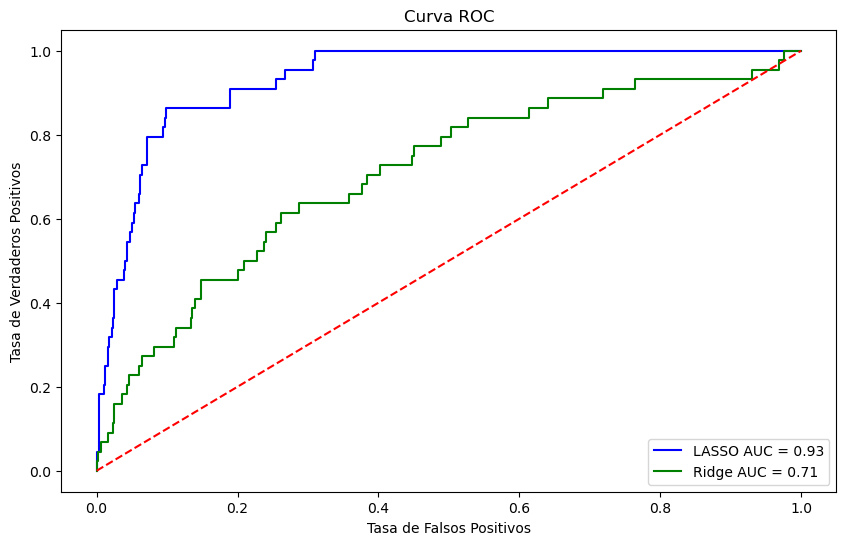

In [378]:
y_prob_lasso = model_lasso.predict_proba(X_test)[:, 1]
y_prob_ridge = model_ridge.predict_proba(X_test)[:, 1]

# Curva ROC
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_prob_ridge)

# AUC
auc_lasso = auc(fpr_lasso, tpr_lasso)
auc_ridge = auc(fpr_ridge, tpr_ridge)

# Graficar la curva ROC
plt.figure(figsize=(10,6))
plt.plot(fpr_lasso, tpr_lasso, color='blue', label=f'LASSO AUC = {auc_lasso:.2f}')
plt.plot(fpr_ridge, tpr_ridge, color='green', label=f'Ridge AUC = {auc_ridge:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [379]:
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)

print("Accuracy LASSO:", accuracy_lasso)
print("Accuracy Ridge:", accuracy_ridge)

Accuracy LASSO: 0.9597946963216424
Accuracy Ridge: 0.962360992301112


In [380]:
# Definir valores de λ (equivalente a alpha en sklearn)
lambdas = [10**n for n in range(-5, 6)]  # valores de λ desde 10^(-5) hasta 10^5
ridge_errors = []  # Para almacenar los errores de Ridge
lasso_errors = []  # Para almacenar los errores de Lasso

ridge_coefs = []  # Para almacenar coeficientes de Ridge
lasso_proportions = []  # Para almacenar las proporciones de coeficientes nulos (Lasso)

for lambda_value in lambdas:
    # Regresión Ridge
    ridge_model = LogisticRegression(penalty='l2', C=1/lambda_value, solver='liblinear')
    ridge_cv_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
    ridge_errors.append(-ridge_cv_scores)  # MSE es negativo por la forma en que se calcula, lo revertimos
    
    # Regresión LASSO
    lasso_model = LogisticRegression(penalty='l1', C=1/lambda_value, solver='liblinear')
    lasso_cv_scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
    lasso_errors.append(-lasso_cv_scores)
    
    # Para Lasso, calculamos la proporción de coeficientes nulos
    lasso_model.fit(X_train_scaled, y_train)
    lasso_coefs = lasso_model.coef_.flatten()
    lasso_proportion = np.mean(lasso_coefs == 0)  # Proporción de coeficientes cero
    lasso_proportions.append(lasso_proportion)

C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Mili\anaconda3\envs\nuevo_entorno\Lib\sit

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\2394696081.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='lambda', y='value', data=pd.melt(ridge_errors_df, id_vars='lambda'), palette="Set2")


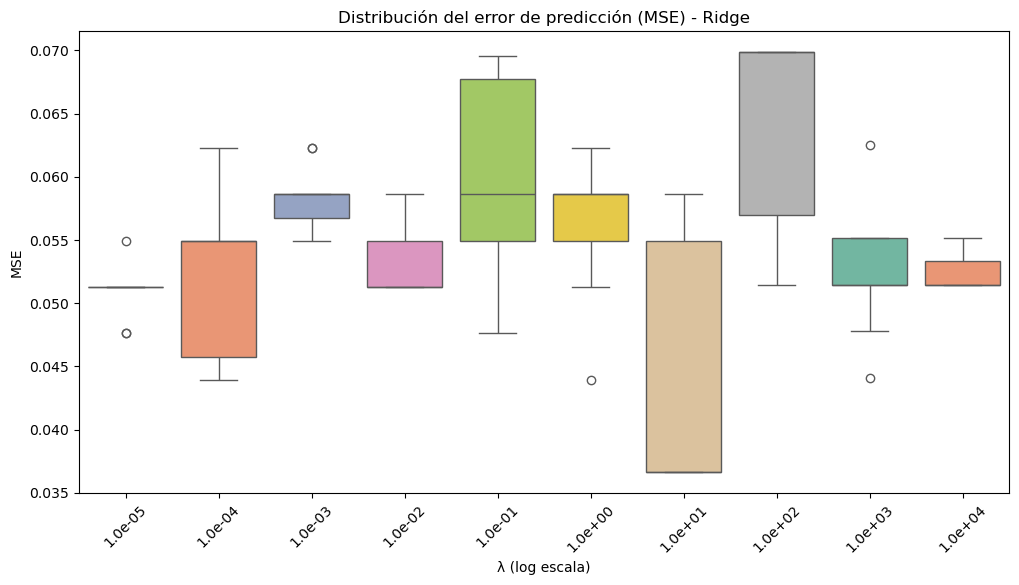

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\2394696081.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='lambda', y='value', data=pd.melt(lasso_errors_df, id_vars='lambda'), palette="Set1")


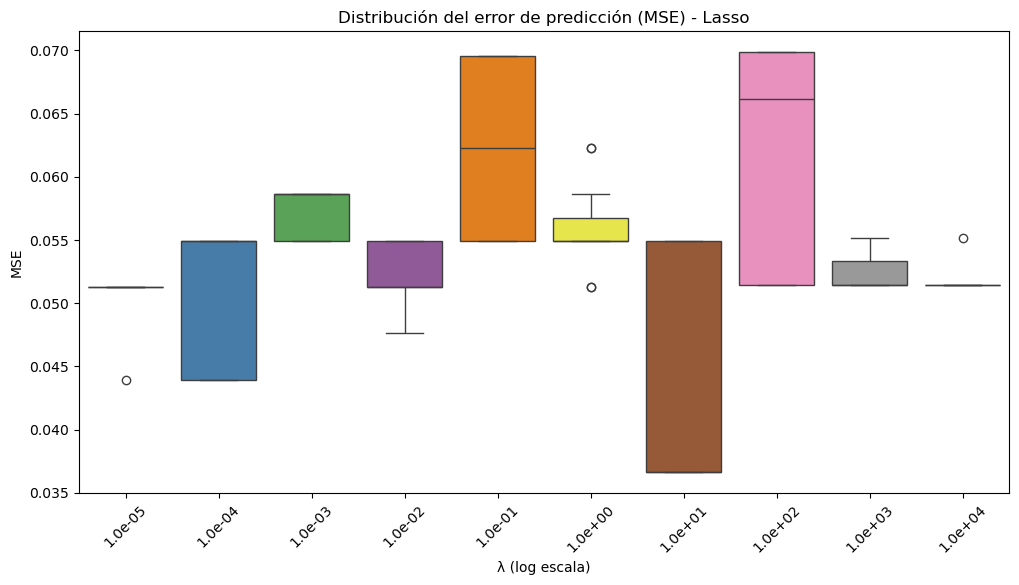

In [386]:
# Convertir los errores a un DataFrame
ridge_errors_df = pd.DataFrame(ridge_errors).T
lasso_errors_df = pd.DataFrame(lasso_errors).T

# Promediar los errores de Ridge y Lasso
ridge_errors_mean = np.mean(ridge_errors_df, axis=1)
lasso_errors_mean = np.mean(lasso_errors_df, axis=1)

# Si lambdas tiene 11 valores, pero solo 10 son utilizados:
lambdas = lambdas[:10]  # Ajustar el tamaño de lambdas a 10

# Ahora agregamos la columna 'lambda' a cada DataFrame
ridge_errors_df['lambda'] = lambdas
lasso_errors_df['lambda'] = lambdas
# Boxplot de errores de Ridge
plt.figure(figsize=(12, 6))
sns.boxplot(x='lambda', y='value', data=pd.melt(ridge_errors_df, id_vars='lambda'), palette="Set2")
plt.title('Distribución del error de predicción (MSE) - Ridge')
plt.xlabel('λ (log escala)')
plt.ylabel('MSE')
plt.xticks(ticks=range(len(lambdas)), labels=[f'{x:.1e}' for x in lambdas], rotation=45)
plt.show()

# Boxplot de errores de Lasso
plt.figure(figsize=(12, 6))
sns.boxplot(x='lambda', y='value', data=pd.melt(lasso_errors_df, id_vars='lambda'), palette="Set1")
plt.title('Distribución del error de predicción (MSE) - Lasso')
plt.xlabel('λ (log escala)')
plt.ylabel('MSE')
plt.xticks(ticks=range(len(lambdas)), labels=[f'{x:.1e}' for x in lambdas], rotation=45)
plt.show()

Con valores pequeños de  λ, los modelos tienden a tener menos regularización, lo que puede llevar a un sobreajuste (overfitting). Esto generalmente se traduce en un MSE más bajo, pero la variabilidad del error puede ser alta.
Con valores grandes de  𝜆, el modelo se vuelve más regularizado y las predicciones tienden a ser más simples, lo que puede aumentar el error (MSE) pero reduce la variabilidad, ya que el modelo es menos propenso a sobreajustarse.
Comparación entre Ridge y Lasso:

Ridge: En el modelo Ridge, la regularización penaliza todos los coeficientes del modelo, pero no los hace cero (a diferencia de Lasso). Esto puede resultar en un MSE más uniforme a través de los valores de  𝜆

Lasso: En Lasso, los coeficientes de algunas variables se reducen a cero, lo que puede llevar a un modelo más simple, pero también más sensible a la elección de 𝜆. Es posible que veas que el MSE de  Lasso varía más drásticamente entre los diferentes valores de 𝜆


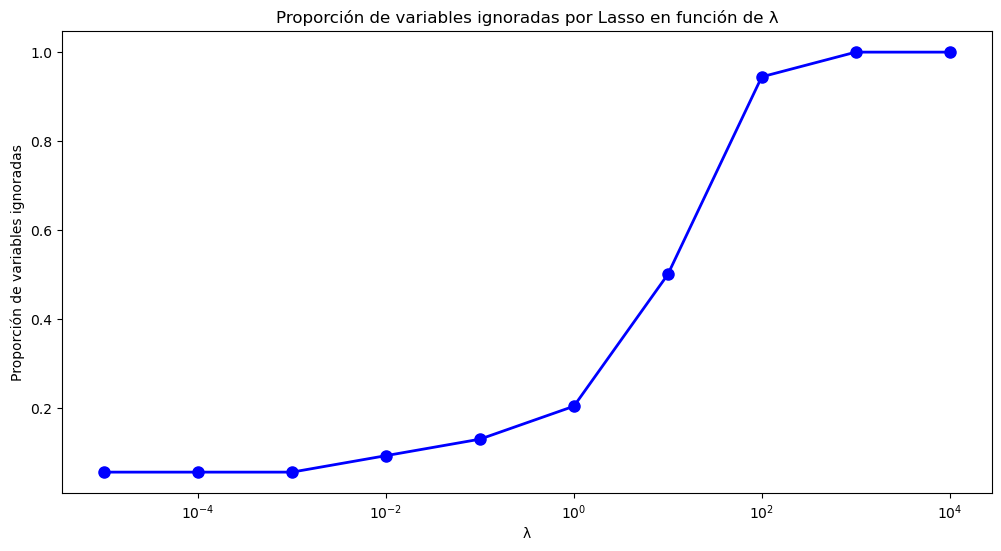

In [388]:
min_len = min(len(lambdas), len(lasso_proportions))
lambdas = lambdas[:min_len]
lasso_proportions = lasso_proportions[:min_len]

# Ahora, puedes hacer el gráfico
plt.figure(figsize=(12, 6))
plt.plot(lambdas, lasso_proportions, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xscale('log')
plt.title('Proporción de variables ignoradas por Lasso en función de λ')
plt.xlabel('λ')
plt.ylabel('Proporción de variables ignoradas')
plt.show()

Al principio, cuando λ es pequeño, el modelo mantiene la mayoría de las variables, por lo que la proporción de variables ignoradas es baja (alrededor de 0% o un valor muy pequeño).
A medida que  λ aumenta, más variables son ignoradas, lo que hace que la proporción de variables ignoradas aumente.
Cuando  λ es muy grande, casi todas las variables son ignoradas, y la proporción se acerca a 100%.

In [393]:
# Suponiendo que tienes una lista o array con los nombres de las columnas
column_names = ['decocur', 'rdecocur', 'gdecocur', 'adecocur', 'desocupado', 
                'proporcion_trabajando', 'total_personas', 'tasa_parcial', 'prom_edad_hogar', 
                'edad', 'ingreso', 'varon', 'mujer', 'con_pareja', 'sin_pareja', 'si_cobertura', 'no_cobertura', 'prim_inc', 'prim_com', 'sec_inc', 'sec_com', 'uni_inc', 'uni_comp', 
                'sin_instrucc', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'v1', 
                'v2', 'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 
                'v18', 'v19_a', 'v19_b', 'itf', 'vii2_1', 'componente', 'ch16']  # Sustituye con los nombres reales de las columnas

# Ahora puedes asociar los coeficientes de Lasso a los nombres de las variables
discarded_variables = [column_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] == 0]

# Imprimir las variables descartadas
print(f"Variables descartadas por Lasso con λ = {optimal_lambda}:")
print(discarded_variables)

Variables descartadas por Lasso con λ = 10:
['decocur', 'gdecocur', 'total_personas', 'tasa_parcial', 'prom_edad_hogar', 'ingreso', 'con_pareja', 'sin_pareja', 'prim_inc', 'uni_inc', 'uni_comp', 'sin_instrucc', 'iv5', 'iv12_1', 'iv12_2', 'v21', 'v22', 'v7', 'v12', 'v13', 'v15', 'v16', 'v18', 'v19_a', 'v19_b', 'itf', 'ch16']


#### 2004

In [428]:
# Base solo datos 2004
df_prediccion_2004 = df_completa[df_completa['ano4'] == 2004]

datos_respondieron_2004_individual = pd.read_csv('2004_respondieron.csv', low_memory=False)

In [429]:
# Obtener las columnas con valores NaN
columnas_con_na = df_prediccion_2004.isna().sum()

# Crear una lista de las columnas que tienen NaN
columnas_con_na_lista = columnas_con_na[columnas_con_na > 0].index.tolist()

# Imprimir la lista
print(columnas_con_na_lista)
# Eliminar columnas con NaN 
df_prediccion_2004 = df_prediccion_2004.dropna(axis=1)

columnas_con_na = df_prediccion_2004.isna().sum()

# Crear una lista de las columnas que tienen NaN
columnas_con_na_lista = columnas_con_na[columnas_con_na > 0].index.tolist()

# Imprimir la lista
print(columnas_con_na_lista)

['ii3_1', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'h15', 'ch03', 'ch08', 'cat_inac', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp06c', 'pp06d', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09b', 'pp09c', 'pp11b2_mes', 'pp11b2_ano', 'pp11b2_dia', 'pp11g_ano', 'pp11g_mes', 'pp11g_dia', 'p21', 'tot_p12', 'p47t', 'decindr', 'rdecindr', 'gdecindr', 'adecindr', 'v2_m', 'v3_m', 'v4_m', 'v5_m', 'v8_m', 'v9_m', 'v10_m', 'v11_m', 'v12_m', 'v18_m', 'v19_am', 'v21_m', 't_vi']
[]


In [430]:
columnas_a_borrar = ['ch06','ch04', 'ch07', 'ch08','nivel_ed', 'ipcf','ano4','cat_ocup','trimestre', 'region', 'mas_500', 'aglomerado', 'v4', 'vii2_4', 'ch11', 'estado', 'pondera', 'iv1']

# Eliminar las columnas con los nombres especificados
df_prediccion_2004 = df_prediccion_2004.drop(columns=[col for col in df_prediccion_2004.columns if any(sub in col for sub in columnas_a_borrar)])

# Verificar que las columnas fueron eliminadas
print(df_prediccion_2004.columns.tolist())



# ELIMINAMOS COLUMNAS QUE TIENEN DATOS NO ANALIZABLES YA TENEMOS MUY POCAS FILAS

# Reemplazar "Sí" por 1 y "No" por 2 en las columnas especificadas
for col in columnas_a_chequear:
    if col in df_prediccion_2004.columns:  # Verificar si la columna existe en el DataFrame
        df_prediccion_2004[col] = df_prediccion_2004[col].replace({"Sí": 1, "No": 2})


# Convertir todas las columnas a numéricas (excepto 'codusu')
df_prediccion_2004 = df_prediccion_2004.apply(
    lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'codusu' else col
)

columnas_excluidas = ['componente', 'decocur', 'rdecocur', 'gdecocur', 'adecocur', 
                      'desocupado', 'proporcion_trabajando', 'total_personas', 
                      'tasa_parcial', 'prom_edad_hogar']



# Verificar las columnas que contienen los valores 0, 9 o 99, excluyendo las columnas específicas
columnas_a_eliminar = [col for col in df_prediccion_2004.columns 
                       if col not in columnas_excluidas and df_prediccion_2004[col].isin([0, 9, 99]).any()]

# Filtrar columnas que realmente existan en el DataFrame antes de intentar eliminarlas
columnas_a_eliminar_existentes = [col for col in columnas_a_eliminar if col in df_prediccion_2004.columns]

# Eliminar las columnas que contienen valores 0, 9 o 99, excluyendo las columnas especificadas
df_prediccion_2004 = df_prediccion_2004.drop(columns=columnas_a_eliminar_existentes)


# Verificar las columnas restantes
print(df_prediccion_2004.columns.tolist())

['codusu', 'nro_hogar', 'realizada', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'componente', 'ch09', 'ch10', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g

C:\Users\Mili\AppData\Local\Temp\ipykernel_2176\1991607207.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prediccion_2004[col] = df_prediccion_2004[col].replace({"Sí": 1, "No": 2})


['codusu', 'nro_hogar', 'realizada', 'iv1', 'iv1_esp', 'iv5', 'v1', 'v2', 'v21', 'v22', 'v3', 'v5', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'idecifr', 'pdecifr', 'ideccfr', 'pdeccfr', 'vii1_1', 'componente', 'ch09', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'pp04b_cod', 'pp04d_cod', 'pp09a_esp', 'pp09c_esp', 'pp11b_cod', 'pp11d_cod', 'decocur', 'idecocur', 'rdecocur', 'gdecocur', 'pdecocur', 'adecocur', 'idecindr', 'pdecindr', 'desocupado', 'proporcion_trabajando', 'total_personas', 'tasa_parcial', 'prom_edad_hogar']


In [431]:
columnas_a_chequear = ['codusu', 'nro_hogar', 'realizada', 'pondera', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'v1', 'v2', 'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'itf', 'vii2_1', 'componente', 'ch16', 'estado', 'decocur', 'rdecocur', 'gdecocur', 'adecocur', 'desocupado', 'proporcion_trabajando', 'total_personas', 'tasa_parcial', 'prom_edad_hogar']

# Lista de columnas a chequear
columnas_a_chequear = ['codusu', 'nro_hogar', 'realizada', 'pondera', 'iv1', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'v1', 'v2', 
                       'v21', 'v22', 'v3', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 
                       'v17', 'v18', 'v19_a', 'v19_b', 'itf', 'vii2_1', 'componente', 'ch16', 'estado', 'decocur', 'rdecocur', 
                       'gdecocur', 'adecocur', 'desocupado', 'proporcion_trabajando', 'total_personas', 'tasa_parcial', 
                       'prom_edad_hogar']



# Verificar qué columnas existen realmente en el DataFrame
columnas_existentes = [columna for columna in columnas_a_chequear if columna in df_prediccion_2004.columns]

# Iterar sobre las columnas existentes y mostrar los valores únicos
for columna in columnas_existentes:
    print(f"Valores únicos en la columna '{columna}':")
    print(df_prediccion_2004[columna].unique())
    print("\n")

Valores únicos en la columna 'codusu':
['125098  ' '125515  ' '125558  ' ... '287998  ' '288171  ' '288405  ']


Valores únicos en la columna 'nro_hogar':
[1. 2. 3.]


Valores únicos en la columna 'realizada':
[1]


Valores únicos en la columna 'iv1':
[nan]


Valores únicos en la columna 'iv5':
[ 1.  2. nan]


Valores únicos en la columna 'v1':
[2 1]


Valores únicos en la columna 'v2':
[1 2]


Valores únicos en la columna 'v21':
[2 1]


Valores únicos en la columna 'v22':
[2 1]


Valores únicos en la columna 'v3':
[2 1]


Valores únicos en la columna 'v5':
[2 1]


Valores únicos en la columna 'v7':
[2 1]


Valores únicos en la columna 'v8':
[2 1]


Valores únicos en la columna 'v9':
[2 1]


Valores únicos en la columna 'v10':
[2 1]


Valores únicos en la columna 'v11':
[2 1]


Valores únicos en la columna 'v12':
[2 1]


Valores únicos en la columna 'v13':
[ 2.  1. nan]


Valores únicos en la columna 'v14':
[2 1]


Valores únicos en la columna 'v15':
[2 1]


Valores únicos en la column